In [1]:
import sys, os
from typing import Any
import numpy as np
import tensorflow as tf
import logging

from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import minmax_scale


In [2]:
sys.path.append("..")

In [3]:
from adik.dataloaders.seq2point import MultitargetQuantileRegressionSeq2PointDataLoader

In [4]:
from adinilm.objs import DatasetProfile, ProfileHandler
from adinilm.src.tf_nilm.data_loader.seq2point_nilm import NILMSeq2PointDataset
from adinilm.utils.paths_manager import PROFILES_DIR, LOG_DIR, DATA_DIR
from adinilm.src.tf_nilm.losses.quantileloss import QuantileLoss 
from adinilm.src.tf_nilm.losses.multiactivationloss import MultiActivationLoss 
from adinilm.src.tf_nilm.models import simple_seq2point

In [5]:
SEQ_LEN = 100
BATCH_SIZE = 256
PROFILE_PATH = DATA_DIR / "NILMTK" / "processed"
BEST = True

In [6]:
def input_transform(data):
        data = minmax_scale(data, feature_range=(0, 1))
        return data

def label1_transform(data):
        norm = lambda data : minmax_scale(data, feature_range=(0, 1))
        data = np.apply_along_axis(norm, 0, data)
        return data

data = NILMSeq2PointDataset(PROFILE_PATH / "val", seq_len=SEQ_LEN,
                        batch_size=BATCH_SIZE,
                        sequence_strategy= MultitargetQuantileRegressionSeq2PointDataLoader,
                        input_transform = input_transform,
                        label_transform = [lambda x: x, label1_transform])

In [7]:
log_dir = "20240917-083628"
checkpoint_file = "best.keras" if BEST else "checkpoint.keras"

In [8]:
CHECKPOINT = LOG_DIR / "tf_nilm" / log_dir / "weights" / checkpoint_file

In [9]:
model = tf.keras.models.load_model(CHECKPOINT)

In [10]:
# ret = model.evaluate(data, batch_size=BATCH_SIZE)

In [11]:
pred = model.predict(data)

3374/3374 ━━━━━━━━━━━━━━━━━━━━ 264s 77ms/step


In [12]:
pred[0].shape, pred[1].shape

((863744, 5, 2), (863744, 5, 5))

In [13]:
states_pred = np.apply_along_axis(lambda x : tf.argmax(x, axis=0), axis=2, arr=pred[0])

In [14]:
states_pred.shape

(863744, 5)

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline

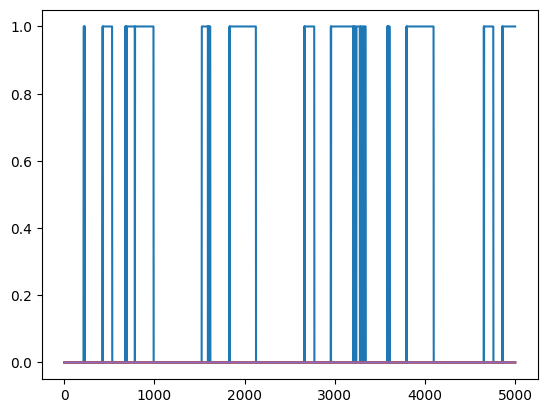

In [16]:
plt.plot(states_pred[4000:9000])

In [17]:
dliter = iter(data)

stat_list = []
rms_list = []
for idx, (inp, lab) in enumerate(dliter):
        stat, pow = lab
        stat_list.append(stat)
        rms_list.append(pow)

In [18]:
stacked = np.vstack(stat_list)
stacked_rms = np.vstack(rms_list)

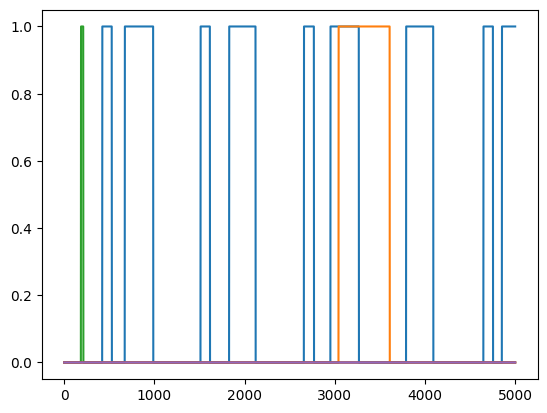

In [19]:
plt.plot(stacked[4000:9000])

In [20]:
states_pred_0 = states_pred[:,0]
states_true_0 = stacked[:,0]

In [21]:
states_true_0.shape

(863744,)

In [22]:
from sklearn.metrics import jaccard_score

In [23]:
jaccard_score(states_true_0, states_pred_0)

0.8397328835458249

In [24]:
states_pred_1 = states_pred[:,1]
states_true_1 = stacked[:,1]
jaccard_score(states_true_1, states_pred_1)

0.013869038166322588

In [25]:
states_pred_2 = states_pred[:,2]
states_true_2 = stacked[:,2]
jaccard_score(states_true_2, states_pred_2)

0.0

In [26]:
states_pred_3 = states_pred[:,3]
states_true_3 = stacked[:,3]
jaccard_score(states_true_3, states_pred_3)

0.007050055393292376

In [27]:
states_pred_4 = states_pred[:,4]
states_true_4 = stacked[:,4]
jaccard_score(states_true_4, states_pred_4)

0.0

In [28]:
def get_eac(target, prediction):
        num = np.abs(target - prediction).sum(axis=0)
        den = 2*target.sum(axis=0)
        return (1 - num/den)

In [29]:
from adinilm.src.tf_nilm.metrics.baseaccuracy import BaseAccuracy

acc = tf.keras.metrics.Accuracy()

In [30]:
acc.reset_state()
acc.update_state(states_true_0, states_pred_0)
acc.result().numpy()

0.93267566

In [31]:
acc.reset_state()
acc.update_state(states_true_1, states_pred_1)
acc.result().numpy()

0.95686454

In [32]:
acc.reset_state()
acc.update_state(states_true_2, states_pred_2)
acc.result().numpy()

0.9966344

In [33]:
acc.reset_state()
acc.update_state(states_true_3, states_pred_3)
acc.result().numpy()

0.9657572

In [34]:
acc.reset_state()
acc.update_state(states_true_4, states_pred_4)
acc.result().numpy()

0.99885154

In [39]:
rms_pred = pred[1][:,:,2]

In [40]:
rms_pred.shape

(863744, 5)

In [46]:
rms_true_0 = stacked_rms[:,0]
rms_pred_0 = rms_pred[:,0]

In [47]:
rms_pred_0 = (rms_pred_0 + 1) / 2

In [49]:
get_eac(rms_true_0, rms_pred_0)

-0.24134774492280853